# Problem Statement
Imagine building a NLP engine that can help predict if a document contains abuse, malignant, defamatory, hateful, racist, fake text or nothing? So this will be a multi-class classification problem which can be converted into n-1 responses (where n = Number of classes), because each document can contain 1 or more classes. Bonus points if you can think of a solution for multiple languages. 

How would you go about mining data for this kind of problem on the web. Site the sources where we can download/scrap or buy data. How would you turn this Active ML problem into a supervised ML Problem? 




**Dataset Used** : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/

**Dataset Explained: <br>**
*Attributes:* "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"


In [1]:
!pwd

/content


Change working directory to Dataset folder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
if os.getcwd() == '/content/drive/My Drive/Datasets':
  pass
else:
  os.chdir('drive/My Drive/Datasets')

Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
import re
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.utils import plot_model
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import json
import nltk
from IPython import display
from statistics import mean 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import Dataset

In [0]:
comments = pd.read_csv('train.csv')

# Preprocessing Data
1. Remove null values
2. Add a new column for (n-1). We add a new column. The new column value will be 1 where all those attributes are 0. This new column will help us with the (n-1) condition.

***Training Data***

In [6]:
print(comments.shape)

comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
# Remove na
filter = comments["comment_text"] != ""
comments = comments[filter]
comments = comments.dropna()

In [0]:
# Add new column
def new_col(row):
    if row['toxic']==0 and row['severe_toxic']==0 and row['obscene']==0 and row['threat']==0 and row['insult']==0 and row['identity_hate']==0:
        val = 1
    else:
        val = 0
    return val

comments['good'] = comments.apply(new_col,axis=1)


In [9]:
# Check if values are added
print(comments.columns)
print(comments['good'].unique())

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'good'],
      dtype='object')
[1 0]


***Testing Data***

In [10]:
comments_test = pd.read_csv('train.csv')
# Remove na
filter = comments_test["comment_text"] != ""
comments_test = comments_test[filter]
comments_test = comments_test.dropna()
comments_test['good'] = comments_test.apply(new_col,axis=1)
print(comments_test.columns)
print(comments_test['good'].unique())

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'good'],
      dtype='object')
[1 0]


# Text Preprocessing

In [0]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
comments_labels = comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
comments_test_labels = comments_test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# Machine Learning Approach

***Preprocess Text***

In [0]:
comments['comment_text'] = comments['comment_text'].apply(lambda x: preprocess_text(x))
comments_test['comment_text'] = comments_test['comment_text'].apply(lambda x: preprocess_text(x))

***Visualize Data***

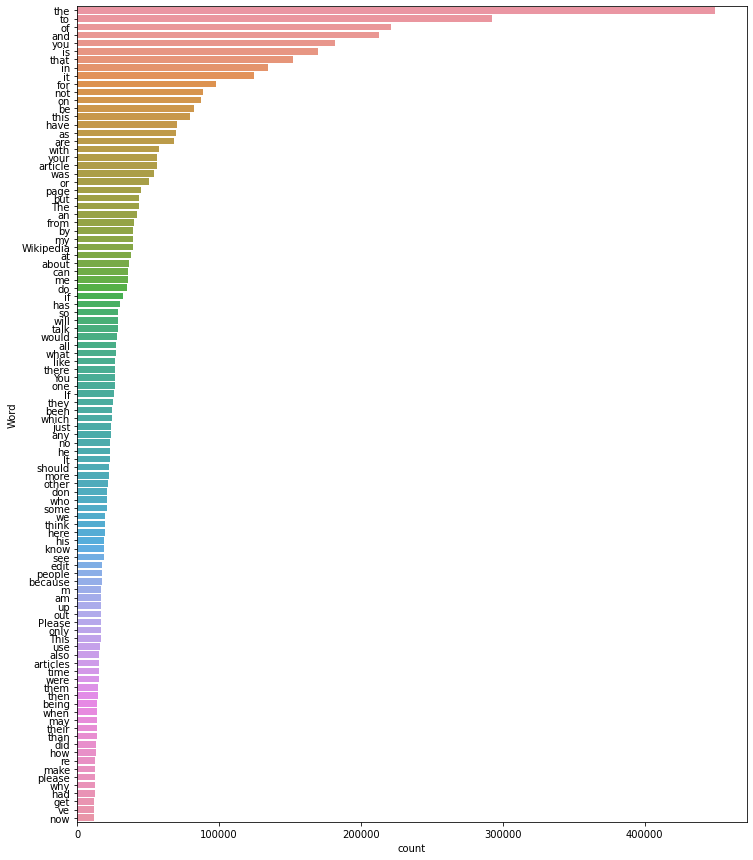

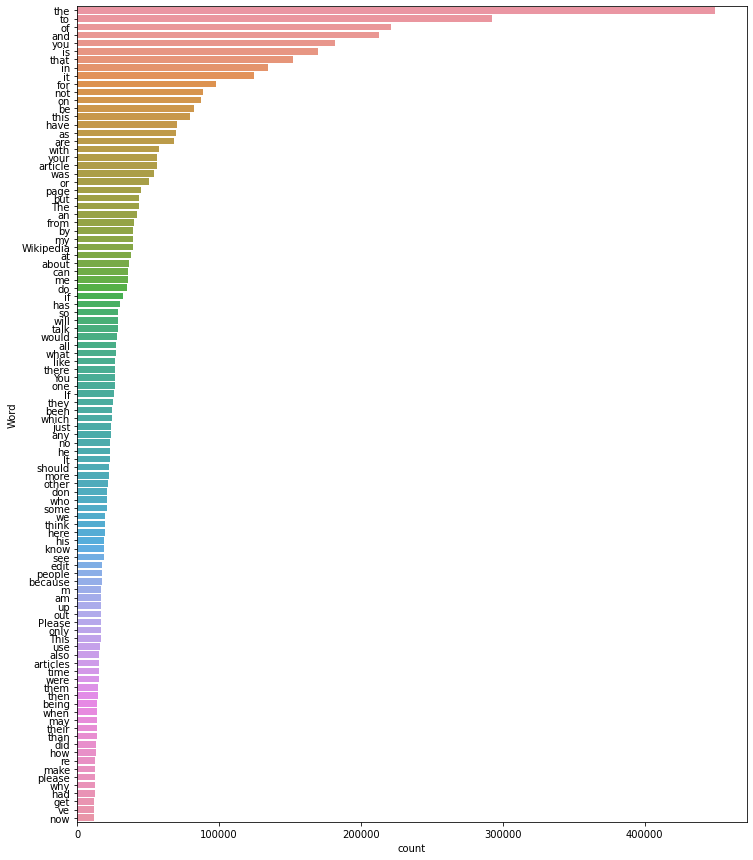

In [14]:
# Word Frequency
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

freq_words(comments['comment_text'], 100)
freq_words(comments_test['comment_text'], 100)

***Remove Stopwords***

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


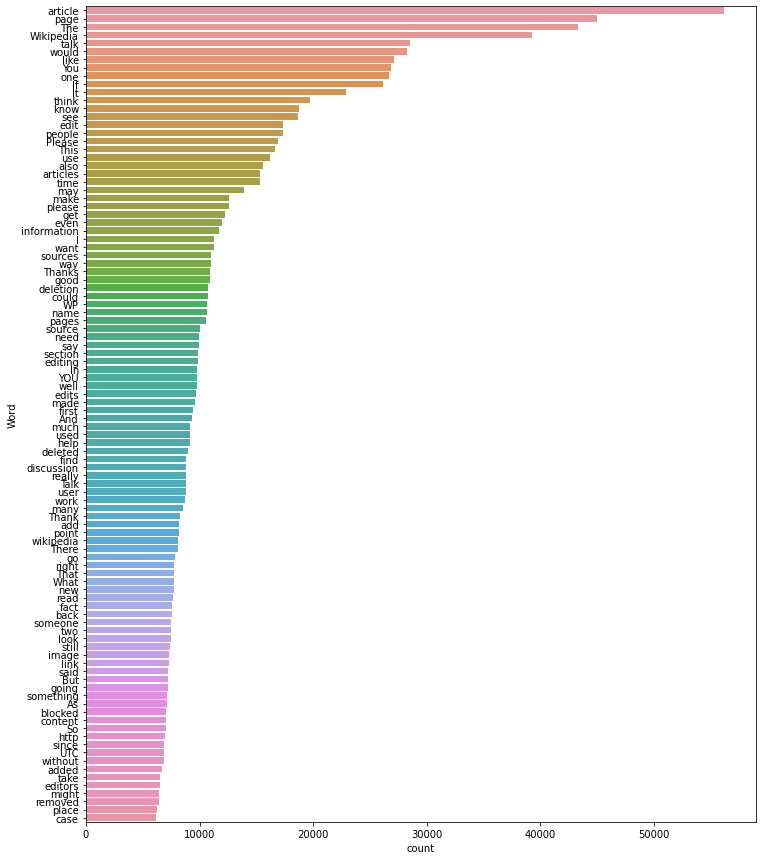

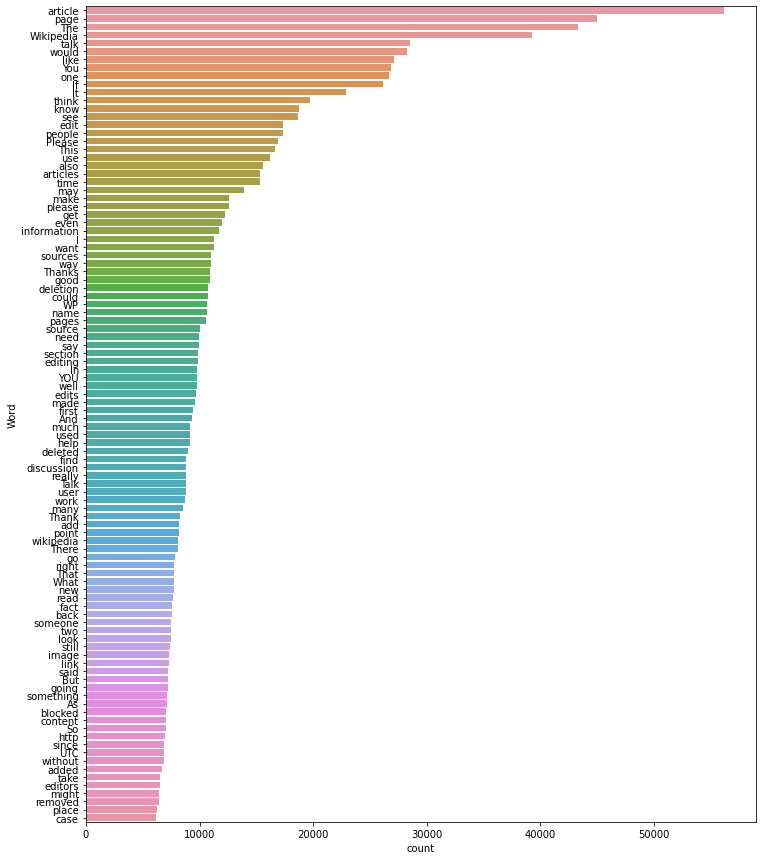

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

comments['comment_text'] = comments['comment_text'].apply(lambda x: remove_stopwords(x))
comments_test['comment_text'] = comments_test['comment_text'].apply(lambda x: remove_stopwords(x))

# Visualize data after removing stop words
freq_words(comments['comment_text'], 100)
freq_words(comments_test['comment_text'], 100)

X & Y Labels

In [0]:
X_train = []
sentences = list(comments["comment_text"])
for sen in sentences:
  X_train.append(preprocess_text(sen))

y_train = comments_labels.values

X_test = []
sentences_test = list(comments_test["comment_text"])
for sen in sentences_test:
  X_test.append(preprocess_text(sen))

y_test = comments_test_labels.values

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

***Create TF-IDF features***

In [0]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train)
xtest_tfidf = tfidf_vectorizer.fit_transform(X_test)

***Creating training model***

In [0]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

lr = LogisticRegression(max_iter=10000) # Increased max_iter from default due to incresed features
clf = OneVsRestClassifier(lr)

This model is continued from here for Active Learning

***Training the model***

In [20]:
clf.fit(xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=10000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

***Predicting***

In [0]:
y_pred = clf.predict(xtest_tfidf)

In [22]:
print('F1 Score:' + str(f1_score(y_test, y_pred, average="micro")))
print('Accuracy Score:' + str(accuracy_score(y_test, y_pred)))

F1 Score:0.7215093056853913
Accuracy Score:0.9256757180189383


# Deep Learning Approach

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_deep = tokenizer.texts_to_sequences(X_train)
X_test_deep = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train_deep = pad_sequences(X_test_deep, padding='post', maxlen=maxlen)
X_test_deep = pad_sequences(X_test_deep, padding='post', maxlen=maxlen)

Convert to word embeddings

In [0]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Model Representation

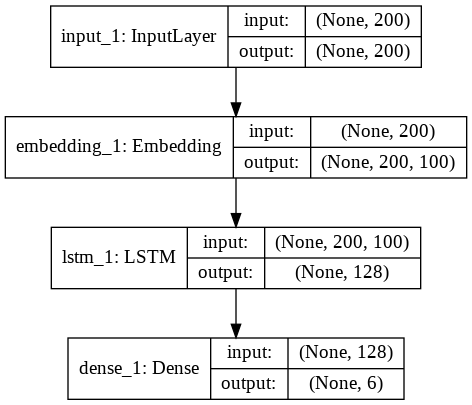

In [0]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Model Training

In [0]:
history = model.fit(X_train_deep, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 838s 7ms/step - loss: 0.1430 - acc: 0.9636 - val_loss: 0.0861 - val_acc: 0.9696
Epoch 2/5
127656/127656 [==============================] - 839s 7ms/step - loss: 0.0660 - acc: 0.9779 - val_loss: 0.0600 - val_acc: 0.9796
Epoch 3/5
127656/127656 [==============================] - 843s 7ms/step - loss: 0.0569 - acc: 0.9803 - val_loss: 0.0591 - val_acc: 0.9804
Epoch 4/5
127656/127656 [==============================] - 842s 7ms/step - loss: 0.0539 - acc: 0.9810 - val_loss: 0.0552 - val_acc: 0.9809
Epoch 5/5
127656/127656 [==============================] - 834s 7ms/step - loss: 0.0519 - acc: 0.9816 - val_loss: 0.0568 - val_acc: 0.9808


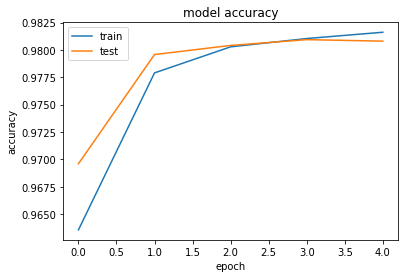

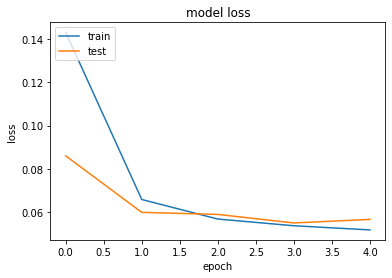

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Active Learning

Thanks to https://www.geeksforgeeks.org/ml-active-learning/

Data Preparation

In [0]:
def split(dataset , train_size, test_size): 
    x = dataset.iloc[:, 1].values
    x_tf = tfidf_vectorizer.fit_transform(x).toarray()
    y = dataset.iloc[:, [2,3,4,5,6,7,8]].values
    x_train, x_pool, y_train, y_pool = train_test_split( 
        x_tf, y, train_size = train_size) 
    unlabel, x_test, label, y_test = train_test_split( 
        x_pool, y_pool, test_size = test_size) 
    return x_train, y_train, x_test, y_test, unlabel, label

In [0]:
if __name__ == '__main__': 
    # run both models 100 times and take the average of their accuracy 
    ac1, ac2 = [], []  # arrays to store accuracy of different models 
  
    for i in range(1): 
        # split dataset into train(5 %), test(25 %), unlabel(70 %) 
        x_train_active, y_train_active, x_test_active, y_test_active, unlabel, label = split(comments, 0.05, 0.25)  
        # train model by active learning 
        for i in range(1): 
            lf1 = LogisticRegression(max_iter=10000)
            classifier1 = OneVsRestClassifier(lf1)
            classifier1.fit(x_train_active, y_train_active.reshape(x_train_active.shape[0],6))
            y_probab = classifier1.predict_proba(unlabel)[:, 0] 
            p = 0.47 # range of uncertanity 0.47 to 0.53 
            uncrt_pt_ind = [] 
            for i in range(unlabel.shape[0]): 
                if(y_probab[i] >= p and y_probab[i] <= 1-p): 
                    uncrt_pt_ind.append(i) 
            x_train_active = np.append(unlabel[uncrt_pt_ind, :], x_train_active, axis = 0) 
            y_train_active = np.append(label[uncrt_pt_ind], y_train) 
            unlabel = np.delete(unlabel, uncrt_pt_ind, axis = 0) 
            label = np.delete(label, uncrt_pt_ind) 
        lf2 = LogisticRegression(max_iter=10000)
        classifier2 = OneVsRestClassifier(lf2) 
        classifier2.fit(x_train_active, y_train_active.reshape(x_train_active.shape[0],6)) 
        ac1.append(classifier2.score(x_test_active, y_test_active.reshape(x_test_active.shape[0],6))) 
  
        ''' split dataset into train(same as generated by our model), 
        test(25 %), unlabel(rest) '''
        train_size = x_train_active.shape[0]/comments.shape[0] 
        x_train_active, y_train_active, x_test_active, y_test_active, unlabel, label = split(comments, train_size, 0.25) 
  
    print("Accuracy by active model :", mean(ac1)*100) 
    print("Accuracy by random sampling :", mean(ac2)*100)